In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
def hextofloats(h):
    '''Takes a hex rgb string (e.g. #ffffff) and returns an RGB tuple (float, float, float).'''
    return tuple(int(h[i:i + 2], 16) / 255. for i in (1, 3, 5)) # skip '#'


Duplicate key in file PosixPath('/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.sans-serif: Arial')


In [2]:
Aminoacid = ['Glycine betaine',
'Ectoine',
'GABA',
'Sarcosine',
'Taurine',
'Proline',
'Glutamate',
'Glutamine']
Aminoacid = sorted(Aminoacid)
Aminoacid.append('TMAO')
AminoAcid_cdict = dict(zip(Aminoacid, sns.color_palette("BuGn_r",len(Aminoacid))))

Sugars = ['Glycerol',
'Mannitol',
'Sorbitol',
'Sucrose',
'Trehalose'
]

Sugars_cdict = dict(zip(Sugars, sns.color_palette("BuPu_r",len(Sugars))))


color_order = [Aminoacid, Sugars]
color_order = [item for sublist in color_order for item in sublist]
color_dict_type = {**AminoAcid_cdict,  **Sugars_cdict}



In [3]:
def MMETSP_groupby(df, level='Division', normalized=True):
    division_MMETSP = df.merge(mmetsp_taxonomy[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = mmetsp_taxonomy.groupby(level)['Notes'].count()
    if normalized:
        division_MMETSP = division_MMETSP.T/total_per_group
        division_MMETSP = division_MMETSP.T
    return(division_MMETSP, total_per_group)
def create_cluster_bar(grouped_MMETSP, total_per_group, size=[12,12],
                       cutoff=False, c=5, genome=False, dropzero=False):
    grouped_MMETSP=grouped_MMETSP.dropna()
    if cutoff: 
        ii=total_per_group>c
        grouped_MMETSP= grouped_MMETSP.loc[ii]
        total_per_group=total_per_group[ii]
    if dropzero:
        ss= grouped_MMETSP[grouped_MMETSP.sum(axis=1)>0].index
        print(ss)
        grouped_MMETSP = grouped_MMETSP.loc[ss]
        total_per_group=total_per_group[ss]
    cluster = sns.clustermap(grouped_MMETSP, cmap='binary', yticklabels=1)
    cluster.fig.set_size_inches(size)
    
    # make some space to the right in the figure
    cluster.gs.update(right=0.95)
    # divide existing axes
    divider = make_axes_locatable(cluster.ax_heatmap)
    divider2 = make_axes_locatable(cluster.ax_col_dendrogram)
    # create new axes for bar plot 
    ax = divider.append_axes("right", size="20%", pad=1.7)
    # create empty space of same size as bar plot axes (don't use this space)
    nax = divider2.new_horizontal(size="20%", pad=1.7)
    target = [t.get_text() for t in np.array(cluster.ax_heatmap.get_yticklabels())]
    ind= np.array([list(grouped_MMETSP.index.values).index(t) for t in target])
    # plot bar plot in ax
    ax.barh(np.arange(len(target)), total_per_group.values[ind], color='k')
    ax.set_yticklabels([])
    ax.set_ylim(-0.5,len(grouped_MMETSP.index)-.5)
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')
    if genome:
        ax.set_xlabel('Total Genomes')
    else:
        ax.set_xlabel('Total Transcriptomes')
    ax.xaxis.set_label_position('top') 
    cluster.cax.set_position([0.1, .8, .02, 0.2])
    cluster.cax.set_ylabel('Proportion Gene present')

    plt.show()
    return(cluster)

def bact_groupby(df, level='phylum', normalized=True):
    division_bact = df.merge(MarRef[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = MarRef.groupby(level)['alt_elev'].count()
    if normalized:
        division_bact = division_bact.T/total_per_group
        division_bact = division_bact.T
    return(division_bact, total_per_group)

In [4]:
bact_synth = pd.read_csv('../predict_synthesis/2021-03-predicted-bacterial-osmolyte-synthesis.tsv', sep ='\t', header=[0, 1], index_col=0)

In [5]:
bact_synth.xs('SYNTHESIS', level=1, drop_level=False, axis=1).sum()

DMSP             SYNTHESIS      0
Ectoine          SYNTHESIS    129
GABA             SYNTHESIS    107
Glutamate        SYNTHESIS    897
Glutamine        SYNTHESIS    895
Glycerol         SYNTHESIS    435
Glycine betaine  SYNTHESIS    316
Hydroxyectoine   SYNTHESIS    104
Mannitol         SYNTHESIS    222
Proline          SYNTHESIS    838
Sarcosine        SYNTHESIS     87
Sorbitol         SYNTHESIS    392
Sucrose          SYNTHESIS    304
TMAO             SYNTHESIS     40
Taurine          SYNTHESIS    218
Trehalose        SYNTHESIS    191
dtype: int64

In [6]:
SYNTH = bact_synth.xs('SYNTHESIS', level=1, drop_level=False, axis=1)
BD = bact_synth.xs('BREAKDOWN', level=1, drop_level=False, axis=1)
SYNTH.columns = SYNTH.columns.droplevel(1)
BD.columns = BD.columns.droplevel(1)
MarRef = pd.read_csv('../MarRef_DBs/MarRef_v5.txt', sep='\t', index_col=44)
mmetsp_taxonomy = pd.read_csv('/vortexfs1/omics/alexander/data/mmetsp/taxonomy_v2.txt', sep='\t',
                              encoding = "ISO-8859-1", index_col='Source_ID')

MarRef['taxon_lineage_ids'] = MarRef['taxon_lineage_ids'].loc[SYNTH.index].str.replace('│','|')

In [7]:
summedbact = pd.DataFrame(SYNTH.sum()/len(SYNTH))
bd = pd.DataFrame(BD.sum()/len(BD))
summedbact=summedbact.merge(bd, left_index=True, right_index=True)
summedbact.columns=['SYNTHESIS', 'BREAKDOWN']
summedbact.sort_values('SYNTHESIS', ascending=False)

,SYNTHESIS,BREAKDOWN
Glutamate,1.000000,1.000000
Glutamine,0.997770,1.000000
Proline,0.934225,1.000000
Glycerol,0.484950,0.770346
Sorbitol,0.437012,0.371237
Glycine betaine,0.352285,0.004459
Sucrose,0.338907,0.636566
Mannitol,0.247492,0.326644
Taurine,0.243032,0.703456
Trehalose,0.212932,0.313266


In [8]:
euk_synth = pd.read_csv('../predict_synthesis/predicted-mmetsp-osmolyte-synthesis.tsv', sep ='\t', header=[0, 1], index_col=0)
euk_synth.index = euk_synth.index.str.strip('_clean')
ESYNTH = euk_synth.xs('SYNTHESIS', level=1, drop_level=False, axis=1)
EBD = euk_synth.xs('BREAKDOWN', level=1, drop_level=False, axis=1)
ESYNTH.columns = ESYNTH.columns.droplevel(1)
EBD.columns = EBD.columns.droplevel(1)

Esummed = pd.DataFrame(ESYNTH.sum()/len(ESYNTH))
Ebd = pd.DataFrame(EBD.sum()/len(EBD))
Esummed=Esummed.merge(Ebd, left_index=True, right_index=True)
Esummed.columns=['SYNTHESIS', 'BREAKDOWN']
Esummed.sort_values('SYNTHESIS', ascending=False)


,SYNTHESIS,BREAKDOWN
Glutamate,0.995399,0.995399
Glutamine,0.993865,0.993865
Glycerol,0.811350,0.858896
Sorbitol,0.765337,0.751534
Sucrose,0.753067,0.644172
Proline,0.535276,0.983129
Trehalose,0.246933,0.361963
Taurine,0.225460,0.475460
GABA,0.214724,0.286810
Mannitol,0.124233,0.056748


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


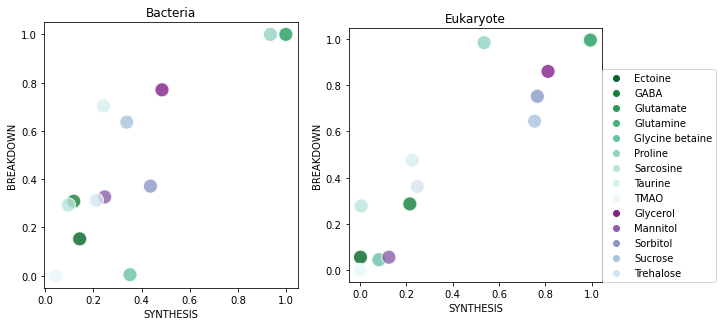

In [9]:
fig, ax = plt.subplots(1,2)
for a in ax:
    a.set_aspect('equal')
fig.set_size_inches(10,10)
cmap='nipy_spectral'
sns.scatterplot(data=summedbact.loc[color_order].reset_index(), x='SYNTHESIS', y='BREAKDOWN',hue='index', 
                ax = ax[0], s=200,palette=color_dict_type,alpha=0.8, legend=None, lw=0)
sns.scatterplot(data=Esummed.loc[color_order].reset_index(), x='SYNTHESIS', y='BREAKDOWN',hue='index', ax = ax[1], 
                marker='o', s=200, palette=color_dict_type, alpha=0.8, lw = 0)
plt.legend(loc=[1,0])
ax[0].set_title('Bacteria')
ax[1].set_title("Eukaryote")


fig.savefig('figures/Comparison_synthesis.pdf')

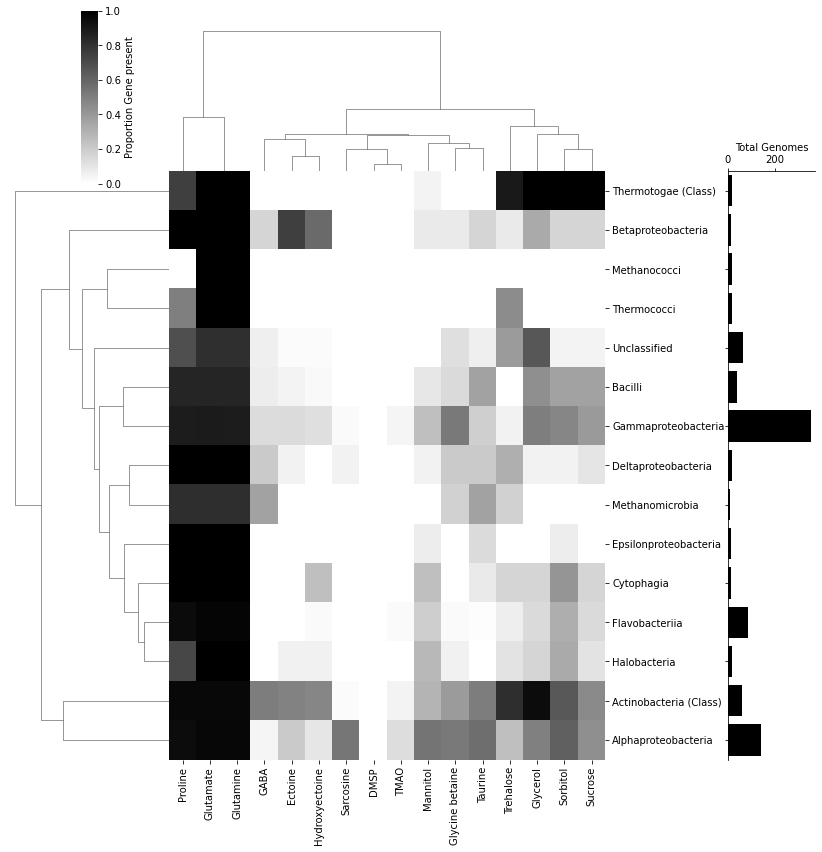

In [10]:
Sdivision_bact, Stotal_bac_group  = bact_groupby(SYNTH,  level='class', normalized=True)
create_cluster_bar(Sdivision_bact, Stotal_bac_group, genome=True, cutoff=True, c=10)

In [11]:
import ete3 

In [12]:
T = ete3.Tree('../GToBacterialTree2/GToBacterialTree2.tre')

In [13]:
T.get_farthest_leaf()

(Tree node 'GCF_000299395.1_Archaea_Thaumarchaeota_NA_Candidatus_Nitrosopumilus_sediminis_AR2' (-0x7ffffd555186e90e),
 3.87465249)

In [14]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()


In [15]:
MarRef['NCBI_taxon_identifier']

assembly_accession_refseq
GCF_000221005.1     520461
GCF_000196255.1     298386
GCF_000195085.1    1002672
GCF_000024465.1     488538
GCF_000267545.1    1196835
                    ...   
GCF_003952245.1      75588
GCF_003970715.1      66425
GCF_004014715.1    1709477
GCF_004014695.1    1628392
GCF_004022545.1     170679
Name: NCBI_taxon_identifier, Length: 970, dtype: int64

In [20]:
MarRef.merge(SYNTH, left_index=True, right_index=True).groupby('phylum')[SYNTH.columns].mean()


,DMSP,Ectoine,GABA,Glutamate,Glutamine,Glycerol,Glycine betaine,Hydroxyectoine,Mannitol,Proline,Sarcosine,Sorbitol,Sucrose,TMAO,Taurine,Trehalose
phylum,,,,,,,,,,,,,,,,
Actinobacteria,0.0,0.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
Actinobacteria (Phylum),0.0,0.491803,0.508197,1.0,1.000000,0.983607,0.409836,0.475410,0.311475,1.000000,0.016393,0.672131,0.475410,0.049180,0.508197,0.852459
Aquificae,0.0,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Aquificae (Phylum),0.0,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bacteroidetes,0.0,0.000000,0.008929,1.0,1.000000,0.241071,0.026786,0.044643,0.187500,0.982143,0.000000,0.330357,0.169643,0.017857,0.026786,0.151786
Calditrichaeota,0.0,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
Chlorobi,0.0,0.000000,0.000000,1.0,1.000000,0.000000,0.200000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000
Chloroflexi,0.0,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
Crenarchaeota,0.0,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375000


In [21]:
test = MarRef['taxon_lineage_ids'].loc[SYNTH.index]
for i in test.index:
    if len(test[i]) <5: 
        print(i, test[i])

In [22]:
test = pd.DataFrame(test)
test[['t0', 't1', 't2','t3']] = test['taxon_lineage_ids'].str.split('|').str[:4].to_list()
gp = test.groupby(['t0', 't1', 't2']).count()
to_group = gp[gp<10].dropna().reset_index()['t2']


In [23]:
targets = ['1224', '1783270','1783272']
gp = test.groupby(['t0', 't1', 't2', 't3']).count().reset_index()
gp[gp['t2'].isin(targets)]

,t0,t1,t2,t3,taxon_lineage_ids
0,131567,2,1224,1236,317
1,131567,2,1224,1553900,2
2,131567,2,1224,28211,138
3,131567,2,1224,28216,12
4,131567,2,1224,580370,2
5,131567,2,1224,68525,34
8,131567,2,1783270,68336,113
9,131567,2,1783270,976,1
10,131567,2,1783272,1117,32
11,131567,2,1783272,1239,49


In [24]:
BD_MERGE = BD.merge(MarRef[['kingdom','phylum','class']], left_index=True, right_index=True)

SYNTH_MERGE = SYNTH.merge(MarRef[['kingdom','phylum','class']], left_index=True, right_index=True)

def make_plotting_groups(test2):
    
    short = ['Aquificae', 'Aquificae (Phylum)', 'Calditrichaeota', 'Chlorobi',
       'Chloroflexi', 'Deferribacteres (Phylum)', 'Deinococcus-Thermus',
       'Fusobacteria', 'Oligoflexia', 'Planctomycetes', 'Spirochaetes',
       'Synergistetes', 'Tenericutes', 'Thermodesulfobacteria (Phylum)',
       'Unclassified', 'Verrucomicrobia', 'Zetaproteobacteria']
    for i in test2.index:
        if test2.loc[i,'phylum'] =='Proteobacteria':
            test2.loc[i, 'plot_grouping'] = test2.loc[i, 'class']
        elif test2.loc[i,'phylum'] == 'Actinobacteria (Phylum)':
            test2.loc[i, 'plot_grouping'] = 'Actinobacteria'
        elif test2.loc[i,'kingdom'] == 'Archaea':
            test2.loc[i, 'plot_grouping'] = 'Archaea'
        elif test2.loc[i, 'phylum'] in short:
            test2.loc[i, 'plot_grouping'] = 'Other'
        else:
            test2.loc[i, 'plot_grouping'] = test2.loc[i, 'phylum']
    return(test2)
BD_MERGE = make_plotting_groups(BD_MERGE)
SYNTH_MERGE = make_plotting_groups(SYNTH_MERGE)

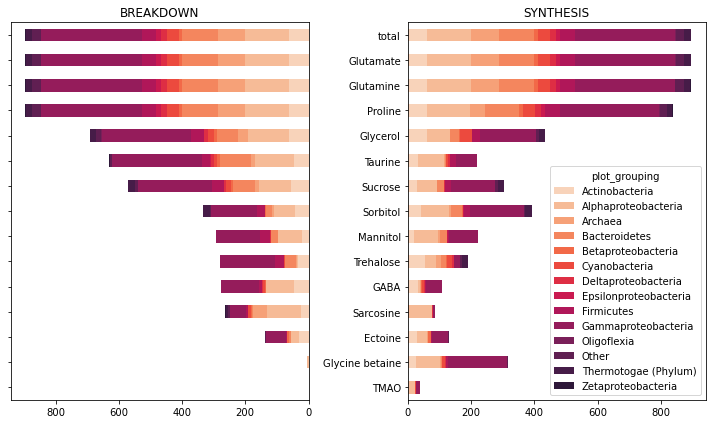

In [25]:
bg = BD_MERGE.groupby('plot_grouping').sum()
sg = SYNTH_MERGE.groupby('plot_grouping').sum()
BD_MERGE.groupby('plot_grouping').count()
bg['total']= BD_MERGE.groupby('plot_grouping').count()['class']
sg['total']= SYNTH_MERGE.groupby('plot_grouping').count()['class']

order = ['TMAO', 'Glycine betaine', 'Ectoine',
       'Sarcosine', 'GABA', 'Trehalose', 'Mannitol', 'Sorbitol', 'Sucrose',
       'Taurine', 'Glycerol', 'Proline', 'Glutamine', 'Glutamate', 'total']
sg=sg[order]
bg = bg[order]
fig, ax = plt.subplots(1,2, figsize=[10,6])
sg.T.plot(kind='barh', stacked=True, ax=ax[1], color=sns.color_palette("rocket_r", 15))
bg.T.plot(kind='barh', stacked=True, ax=ax[0], legend=None ,  color=sns.color_palette("rocket_r", 15))
ax[0].set_title('BREAKDOWN')
ax[0].invert_xaxis()
ax[1].set_title('SYNTHESIS')
ax[0].set_yticklabels([]);
# ax[1].legend(loc=[1,0], )
fig.tight_layout()
fig.savefig('figures/Bacteria-Synthesis-Breakdown.pdf')

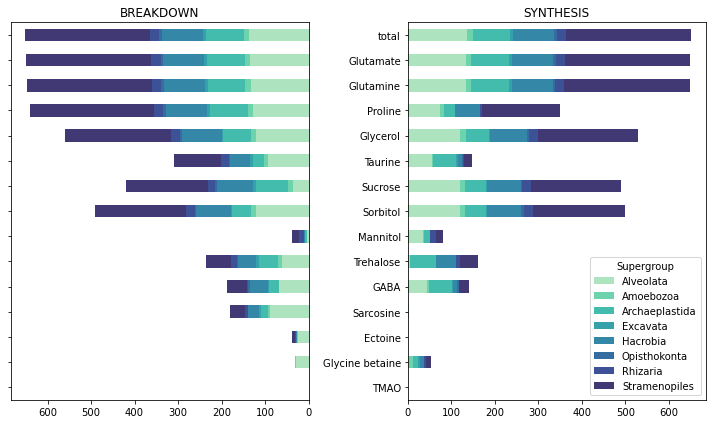

In [26]:
ESYNTH_MERGE = ESYNTH.merge(mmetsp_taxonomy, left_index=True, right_index=True).groupby('Supergroup').sum()[SYNTH.columns]
EBD_MERGE = EBD.merge(mmetsp_taxonomy, left_index=True, right_index=True).groupby('Supergroup').sum()[SYNTH.columns]
ESYNTH_MERGE['total'] = ESYNTH.merge(mmetsp_taxonomy, left_index=True, right_index=True).groupby('Supergroup').count()['Notes']
EBD_MERGE['total'] = EBD.merge(mmetsp_taxonomy, left_index=True, right_index=True).groupby('Supergroup').count()['Notes']

fig, ax = plt.subplots(1,2, figsize=[10,6])
ESYNTH_MERGE[order].T.plot(kind='barh', stacked=True, ax=ax[1], color=sns.color_palette("mako_r", 10))
EBD_MERGE[order].T.plot(kind='barh', stacked=True, ax=ax[0], legend=None, color=sns.color_palette("mako_r", 10))
ax[0].set_title('BREAKDOWN')
ax[0].invert_xaxis()
ax[1].set_title('SYNTHESIS')
ax[0].set_yticklabels([]);
# ax[1].legend(loc=[1,0], )
fig.tight_layout()
fig.savefig('figures/Synthesis-Breakdown-EUKS.pdf')

In [27]:
SS= pd.DataFrame(columns = ['EUK', 'PROK'])
BB= pd.DataFrame(columns = ['EUK', 'PROK'])
SS['EUK']=ESYNTH.sum()/len(ESYNTH)
SS['PROK']=SYNTH.sum()/len(SYNTH)
BB['EUK']=EBD.sum()/len(ESYNTH)
BB['PROK']=BD.sum()/len(SYNTH)

# fig, ax = plt.subplots(1,2, figsize=[8,8])
# for a in ax:
#     a.set_aspect('equal')

# sns.scatterplot(data = SS.loc[order[:-1]], y='EUK', x='PROK', hue='index', ax=ax[0],marker='o', s=200, palette=cmap, alpha=0.8, lw = 0)
# # BB.loc[order[:-1]].plot(kind='scatter', y='EUK', x='PROK', ax=ax[1], marker='o', s=200, palette=cmap, alpha=0.8, lw = 0)

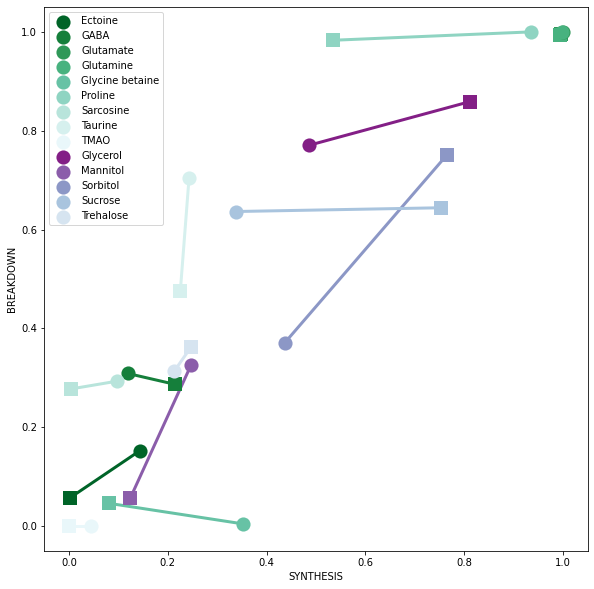

In [28]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal')
fig.set_size_inches(10,10)
colors = sns.color_palette("mako", 15)
for data, color in zip(color_order, colors):
    ax.plot([SS.loc[data, 'EUK'],SS.loc[data, 'PROK']],[BB.loc[data,'EUK'],BB.loc[data,'PROK']], 
            color=color_dict_type[data], lw=3)

    ax.scatter(x=SS.loc[data, 'PROK'], y=BB.loc[data,'PROK'],
                s=200,alpha=1, lw=0, color= color_dict_type[data], label = data, zorder=101)
    ax.scatter(x=SS.loc[data, 'EUK'], y=BB.loc[data,'EUK'],
                s=200,alpha=1, lw=0,  color= color_dict_type[data], marker='s', zorder=100)
    ax.set_xlabel('SYNTHESIS')
    ax.set_ylabel('BREAKDOWN')

plt.legend()
# sns.scatterplot(data=Esummed.reset_index(), x='SYNTHESIS', y='BREAKDOWN',hue='index', ax = ax[1], 
#                 marker='o', s=200, palette=cmap, alpha=0.8, lw = 0)
# plt.legend(loc=[1,0])
fig.savefig('figures/Comparison_synthesis-direct.pdf')

In [29]:
len(order)

15

In [30]:
columns = ['genome_length','gc_content','genes']
SYNTH_MERGE2 = SYNTH_MERGE.merge(MarRef[columns], left_index=True, right_index=True)
SYNTH_MERGE2

,DMSP,Ectoine,GABA,Glutamate,Glutamine,Glycerol,Glycine betaine,Hydroxyectoine,Mannitol,Proline,...,TMAO,Taurine,Trehalose,kingdom,phylum,class,plot_grouping,genome_length,gc_content,genes
GCF_000006175.1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,Archaea,Euryarchaeota,Methanococci,Archaea,1936388,28.59,1741
GCF_000007225.1,0,0,0,1,1,0,0,0,0,1,...,0,0,1,Archaea,Crenarchaeota,Thermoprotei,Archaea,2222431,51.36,2545
GCF_000007305.1,0,0,0,1,1,0,0,0,0,1,...,0,0,1,Archaea,Euryarchaeota,Thermococci,Archaea,1908257,40.77,2121
GCF_000007925.1,0,0,0,1,1,1,0,0,0,1,...,0,0,0,Bacteria,Cyanobacteria,Unclassified,Cyanobacteria,1751081,36.44,2464
GCF_000008465.1,0,0,0,1,1,0,0,0,0,1,...,0,0,0,Bacteria,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria,2839319,47.04,2722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_900476435.1,0,0,0,1,1,0,0,0,0,1,...,0,0,0,Bacteria,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria,4353505,45.86,3958
GCF_900538275.1,0,0,0,1,1,1,0,0,0,1,...,0,0,1,Bacteria,Firmicutes,Clostridia,Firmicutes,3518882,37.27,3229
GCF_900574125.1,0,1,0,1,1,0,1,0,1,1,...,0,1,0,Bacteria,Proteobacteria,Alphaproteobacteria,Alphaproteobacteria,4712067,59.07,4498
GCF_900636325.1,0,0,0,1,1,1,0,0,0,1,...,0,0,0,Bacteria,Firmicutes,Bacilli,Firmicutes,2798161,37.80,2633


In [31]:

meta_cols = ['DMSP', 'Ectoine', 'GABA', 'Glutamate', 'Glutamine', 'Glycerol',
       'Glycine betaine', 'Hydroxyectoine', 'Mannitol', 'Proline', 'Sarcosine',
       'Sorbitol', 'Sucrose', 'TMAO', 'Taurine', 'Trehalose','genome_length']

for n, g in SYNTH_MERGE2.groupby('plot_grouping'):
    print(n)
    print(g)
    if n=='Alphaproteobacteria':
        break

Actinobacteria
                 DMSP  Ectoine  GABA  Glutamate  Glutamine  Glycerol  \
GCF_000010105.1     0        1     1          1          1         1   
GCF_000016425.1     0        0     1          1          1         1   
GCF_000018265.1     0        0     1          1          1         1   
GCF_000018885.1     0        0     1          1          1         1   
GCF_000023925.1     0        1     0          1          1         0   
...               ...      ...   ...        ...        ...       ...   
GCF_900091425.1     0        0     0          1          1         1   
GCF_900099705.1     0        0     0          1          1         1   
GCF_900102005.1     0        0     0          1          1         1   
GCF_900105445.1     0        0     0          1          1         1   
GCF_900105865.1     0        0     0          1          1         1   

                 Glycine betaine  Hydroxyectoine  Mannitol  Proline  ...  \
GCF_000010105.1                0            

In [32]:
data = g[['Mannitol','genome_length']]

In [33]:
data.genome_length=data.genome_length.astype(float)

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [38]:
order

['TMAO',
 'Glycine betaine',
 'Ectoine',
 'Sarcosine',
 'GABA',
 'Trehalose',
 'Mannitol',
 'Sorbitol',
 'Sucrose',
 'Taurine',
 'Glycerol',
 'Proline',
 'Glutamine',
 'Glutamate',
 'total']

In [39]:
ESYNTH

,DMSP,Ectoine,GABA,Glutamate,Glutamine,Glycerol,Glycine betaine,Hydroxyectoine,Mannitol,Proline,Sarcosine,Sorbitol,Sucrose,TMAO,Taurine,Trehalose
MMETSP1380,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
MMETSP0409,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
MMETSP0320,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0
MMETSP1374,0,0,0,1,1,1,0,0,1,1,0,1,1,0,0,0
MMETSP0907,0,0,0,1,1,1,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MMETSP1019,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
MMETSP0093,0,0,0,1,1,1,0,0,0,1,0,1,1,0,1,0
MMETSP1433,0,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0
MMETSP0736,0,0,0,1,1,1,0,0,0,1,0,1,1,0,0,0


In [40]:
SYNTH

,DMSP,Ectoine,GABA,Glutamate,Glutamine,Glycerol,Glycine betaine,Hydroxyectoine,Mannitol,Proline,Sarcosine,Sorbitol,Sucrose,TMAO,Taurine,Trehalose
GCF_000210915.2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
GCF_000590925.1,0,0,0,1,1,0,1,0,1,1,1,1,0,1,0,0
GCF_001044335.1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0
GCF_000015645.1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0
GCF_000485905.1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_000010405.1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
GCF_000178875.2,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0
GCF_002983865.1,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0
GCF_000439495.1,0,0,0,1,1,0,1,0,1,1,0,1,0,0,0,0


In [41]:
SYNTH_MERGE

,DMSP,Ectoine,GABA,Glutamate,Glutamine,Glycerol,Glycine betaine,Hydroxyectoine,Mannitol,Proline,Sarcosine,Sorbitol,Sucrose,TMAO,Taurine,Trehalose,kingdom,phylum,class,plot_grouping
GCF_000006175.1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,Archaea,Euryarchaeota,Methanococci,Archaea
GCF_000007225.1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,Archaea,Crenarchaeota,Thermoprotei,Archaea
GCF_000007305.1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,Archaea,Euryarchaeota,Thermococci,Archaea
GCF_000007925.1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,Bacteria,Cyanobacteria,Unclassified,Cyanobacteria
GCF_000008465.1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,Bacteria,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_900476435.1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,Bacteria,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria
GCF_900538275.1,0,0,0,1,1,1,0,0,0,1,0,1,1,0,0,1,Bacteria,Firmicutes,Clostridia,Firmicutes
GCF_900574125.1,0,1,0,1,1,0,1,0,1,1,1,1,0,0,1,0,Bacteria,Proteobacteria,Alphaproteobacteria,Alphaproteobacteria
GCF_900636325.1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,Bacteria,Firmicutes,Bacilli,Firmicutes


In [42]:
metabolite = 'Sucrose'
(sg.T/sg.total).T[metabolite].sort_values()

plot_grouping
Cyanobacteria            0.000000
Epsilonproteobacteria    0.000000
Oligoflexia              0.000000
Zetaproteobacteria       0.000000
Archaea                  0.023256
Deltaproteobacteria      0.105263
Betaproteobacteria       0.166667
Bacteroidetes            0.169643
Other                    0.250000
Firmicutes               0.413043
Gammaproteobacteria      0.444795
Alphaproteobacteria      0.453237
Actinobacteria           0.467742
Thermotogae (Phylum)     1.000000
Name: Sucrose, dtype: float64

In [52]:
(sg.T/sg.total).T

,TMAO,Glycine betaine,Ectoine,Sarcosine,GABA,Trehalose,Mannitol,Sorbitol,Sucrose,Taurine,Glycerol,Proline,Glutamine,Glutamate,total
plot_grouping,,,,,,,,,,,,,,,
Actinobacteria,0.048387,0.419355,0.483871,0.016129,0.516129,0.854839,0.306452,0.661290,0.467742,0.516129,0.983871,1.000000,1.000000,1.0,1.0
Alphaproteobacteria,0.136691,0.539568,0.215827,0.553957,0.043165,0.258993,0.561151,0.640288,0.453237,0.582734,0.510791,0.978417,1.000000,1.0,1.0
Archaea,0.000000,0.034884,0.046512,0.000000,0.046512,0.186047,0.058140,0.069767,0.023256,0.046512,0.034884,0.523256,1.000000,1.0,1.0
Bacteroidetes,0.017857,0.026786,0.000000,0.000000,0.008929,0.151786,0.187500,0.330357,0.169643,0.026786,0.241071,0.982143,1.000000,1.0,1.0
Betaproteobacteria,0.000000,0.083333,0.750000,0.000000,0.166667,0.083333,0.083333,0.166667,0.166667,0.166667,0.333333,1.000000,1.000000,1.0,1.0
Cyanobacteria,0.026316,0.236842,0.000000,0.000000,0.157895,0.421053,0.000000,0.000000,0.000000,0.157895,0.973684,0.973684,1.000000,1.0,1.0
Deltaproteobacteria,0.000000,0.210526,0.052632,0.052632,0.210526,0.315789,0.052632,0.052632,0.105263,0.210526,0.052632,1.000000,1.000000,1.0,1.0
Epsilonproteobacteria,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.071429,0.000000,0.142857,0.000000,1.000000,1.000000,1.0,1.0
Firmicutes,0.000000,0.152174,0.043478,0.000000,0.065217,0.021739,0.108696,0.434783,0.413043,0.369565,0.521739,0.978261,1.000000,1.0,1.0


In [58]:
bg.totall.sum()

897

In [44]:
bg[metabolite].sum()/bg.total.sum()

0.6365663322185061

In [45]:
sg[metabolite].sum()/sg.total.sum()

0.33890746934225197

In [55]:
(EBD_MERGE.T/EBD_MERGE.total).T

,DMSP,Ectoine,GABA,Glutamate,Glutamine,Glycerol,Glycine betaine,Hydroxyectoine,Mannitol,Proline,Sarcosine,Sorbitol,Sucrose,TMAO,Taurine,Trehalose,total
Supergroup,,,,,,,,,,,,,,,,,
Alveolata,0.000000,0.175182,0.489051,0.985401,0.970803,0.875912,0.211679,0.0,0.029197,0.934307,0.649635,0.875912,0.262774,0.0,0.678832,0.452555,1.0
Amoebozoa,0.000000,0.166667,0.083333,1.000000,1.000000,1.000000,0.083333,0.0,0.000000,1.000000,0.416667,1.000000,1.000000,0.0,0.833333,0.750000,1.0
Archaeplastida,0.000000,0.000000,0.275862,1.000000,1.000000,0.747126,0.000000,0.0,0.057471,1.000000,0.183908,0.517241,0.827586,0.0,0.287356,0.505747,1.0
Excavata,0.000000,0.000000,0.142857,1.000000,1.000000,0.428571,0.000000,0.0,0.000000,1.000000,0.571429,0.285714,1.000000,0.0,0.857143,0.714286,1.0
Hacrobia,0.000000,0.021277,0.446809,0.989362,1.000000,0.957447,0.000000,0.0,0.010638,1.000000,0.265957,0.851064,0.882979,0.0,0.489362,0.457447,1.0
Opisthokonta,0.000000,0.000000,0.833333,1.000000,1.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.333333,0.833333,0.0,0.500000,0.333333,1.0
Rhizaria,0.000000,0.095238,0.095238,1.000000,1.000000,1.000000,0.000000,0.0,0.571429,1.000000,0.285714,1.000000,0.761905,0.0,0.857143,0.619048,1.0
Stramenopiles,0.003472,0.024306,0.156250,1.000000,1.000000,0.843750,0.000000,0.0,0.052083,0.993056,0.125000,0.722222,0.656250,0.0,0.378472,0.201389,1.0


In [60]:
(ESYNTH_MERGE.T/ESYNTH_MERGE.total).T

,DMSP,Ectoine,GABA,Glutamate,Glutamine,Glycerol,Glycine betaine,Hydroxyectoine,Mannitol,Proline,Sarcosine,Sorbitol,Sucrose,TMAO,Taurine,Trehalose,total
Supergroup,,,,,,,,,,,,,,,,,
Alveolata,0.0,0.000000,0.321168,0.978102,0.978102,0.883212,0.014599,0.175182,0.248175,0.532847,0.014599,0.875912,0.875912,0.0,0.408759,0.036496,1.0
Amoebozoa,0.0,0.000000,0.333333,1.000000,1.000000,1.000000,0.750000,0.166667,0.250000,0.916667,0.083333,1.000000,1.000000,0.0,0.250000,0.083333,1.0
Archaeplastida,0.0,0.000000,0.609195,1.000000,1.000000,0.620690,0.137931,0.000000,0.149425,0.275862,0.000000,0.540230,0.540230,0.0,0.609195,0.666667,1.0
Excavata,0.0,0.000000,0.571429,1.000000,1.000000,0.428571,0.571429,0.000000,0.000000,0.142857,0.000000,0.285714,0.285714,0.0,0.571429,0.142857,1.0
Hacrobia,0.0,0.010638,0.095745,1.000000,0.989362,0.882979,0.117021,0.021277,0.010638,0.595745,0.000000,0.851064,0.851064,0.0,0.095745,0.478723,1.0
Opisthokonta,0.0,0.000000,0.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.333333,0.000000,1.000000,0.333333,0.0,0.500000,0.000000,1.0
Rhizaria,0.0,0.000000,0.047619,1.000000,1.000000,1.000000,0.142857,0.095238,0.619048,0.190476,0.000000,1.000000,1.000000,0.0,0.047619,0.523810,1.0
Stramenopiles,0.0,0.000000,0.076389,1.000000,1.000000,0.795139,0.041667,0.024306,0.059028,0.618056,0.000000,0.732639,0.718750,0.0,0.062500,0.138889,1.0


In [48]:
EBD.sum()/649

DMSP               0.001541
Ectoine            0.057011
GABA               0.288136
Glutamate          1.000000
Glutamine          0.998459
Glycerol           0.862866
Glycine betaine    0.046225
Hydroxyectoine     0.000000
Mannitol           0.057011
Proline            0.987673
Sarcosine          0.278891
Sorbitol           0.755008
Sucrose            0.647149
TMAO               0.000000
Taurine            0.477658
Trehalose          0.363636
dtype: float64

In [49]:
ESYNTH_MERGE

,DMSP,Ectoine,GABA,Glutamate,Glutamine,Glycerol,Glycine betaine,Hydroxyectoine,Mannitol,Proline,Sarcosine,Sorbitol,Sucrose,TMAO,Taurine,Trehalose,total
Supergroup,,,,,,,,,,,,,,,,,
Alveolata,0,0,44,134,134,121,2,24,34,73,2,120,120,0,56,5,137
Amoebozoa,0,0,4,12,12,12,9,2,3,11,1,12,12,0,3,1,12
Archaeplastida,0,0,53,87,87,54,12,0,13,24,0,47,47,0,53,58,87
Excavata,0,0,4,7,7,3,4,0,0,1,0,2,2,0,4,1,7
Hacrobia,0,1,9,94,93,83,11,2,1,56,0,80,80,0,9,45,94
Opisthokonta,0,0,3,6,6,6,0,0,0,2,0,6,2,0,3,0,6
Rhizaria,0,0,1,21,21,21,3,2,13,4,0,21,21,0,1,11,21
Stramenopiles,0,0,22,288,288,229,12,7,17,178,0,211,207,0,18,40,288


In [50]:

MarRef[MarRef['phylum']=='Cyanobacteria'].head()

,base_ID,alt_elev,collection_date,depth,env_biome,env_feature,env_material,env_package,env_salinity,env_temp,...,estimated_contamination,strain_heterogeneity,qs,mapping,mapping_version,quality_assessment,quality_assessment_version,assembly_version,binning,binning_version
assembly_accession_refseq,,,,,,,,,,,,,,,,,,,,,
GCF_000737535.1,43,missing,2007-09,0,Marine pelagic biome (ENVO:01000023),Marine photic zone (ENVO:00000209),Sea water (ENVO:00002149),Water,missing,missing,...,0.00,0.0,99.46,missing,missing,CheckM,1.0.13,2.3,missing,missing
GCF_000737575.1,46,missing,2004-03,20,Marginal sea biome (ENVO:01000046),Sea coast (ENVO:00000303),Sea water (ENVO:00002149),Water,missing,missing,...,0.00,0.0,99.37,missing,missing,CheckM,1.0.13,2.3,missing,missing
GCF_000737595.1,47,missing,2005-05,30,Marginal sea biome (ENVO:01000046),Sea coast (ENVO:00000303),Sea water (ENVO:00002149),Water,missing,missing,...,0.00,0.0,100.00,missing,missing,CheckM,1.0.13,2.3,missing,missing
GCF_000015645.1,73,missing,1995-11,50,Marginal sea biome (ENVO:01000046),Sea coast (ENVO:00000303),Sea water (ENVO:00002149),Water,missing,missing,...,0.00,0.0,99.64,missing,missing,CheckM,1.0.13,missing,missing,missing
GCF_001040845.1,76,missing,1980,1|5,Marginal sea biome (ENVO:01000046),Sea coast (ENVO:00000303),Sea water (ENVO:00002149),Water,missing,missing,...,0.27,0.0,98.38,missing,missing,CheckM,1.0.13,2015-01,missing,missing


In [51]:
df

""
